# Explaining Outcomes from Black Box Models

This notebook demonstrates how SLISE can be used to explain outcomes from black box models.

## Prerequisites

The example in this notebook assumes that SLISE is installed, which can be done with:
```sh
pip install https://github.com/edahelsinki/pyslise
```
We also need Keras (Tensorflow) for the neural network:

In [1]:
import numpy as np
from tensorflow import keras
import slise
from slise.plot import BW_COLORMAP
from matplotlib import pyplot as plt
from scipy.stats import gaussian_kde

plt.rcParams['figure.figsize'] = [10, 6]

## Dataset

The dataset is the boston housing dataset with 13 variables where the task is to predict the median value of homes in different areas.

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data()
variables = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]

## Model

AS a black box model we use a simple neural network with three hidden layers, ReLU activations, batch normalisation, and dropout.

In [3]:
model = keras.Sequential(
    [
        keras.Input(shape=13),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1),
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                448       
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3

In [4]:
model.compile(loss = "mean_squared_error", optimizer="adam")
model.fit(x_train, y_train, batch_size=64, epochs=16, validation_split=0.1)
print("Test loss:", model.evaluate(x_test, y_test))

Epoch 1/16
6/6 [==============================] - 0s 21ms/step - loss: 577.6099 - val_loss: 366.8981
Epoch 2/16
6/6 [==============================] - 0s 3ms/step - loss: 553.4960 - val_loss: 363.2468
Epoch 3/16
6/6 [==============================] - 0s 2ms/step - loss: 529.3718 - val_loss: 352.1436
Epoch 4/16
6/6 [==============================] - 0s 2ms/step - loss: 504.6755 - val_loss: 340.8665
Epoch 5/16
6/6 [==============================] - 0s 3ms/step - loss: 481.6693 - val_loss: 329.2967
Epoch 6/16
6/6 [==============================] - 0s 3ms/step - loss: 456.9200 - val_loss: 321.9654
Epoch 7/16
6/6 [==============================] - 0s 3ms/step - loss: 434.9183 - val_loss: 315.8674
Epoch 8/16
6/6 [==============================] - 0s 2ms/step - loss: 414.8132 - val_loss: 310.7407
Epoch 9/16
6/6 [==============================] - 0s 3ms/step - loss: 386.6419 - val_loss: 305.9851
Epoch 10/16
6/6 [==============================] - 0s 2ms/step - loss: 356.7679 - val_loss: 301.888

## Explanation

To create the explanation we instruct SLISE to use normalisation, since the variables have widely different magnitudes. This also enables us to use L1 regularisation to create sparser explanations.

In [15]:
item = 3
explanation = slise.explain(x_train, y_train, 0.3, item, lambda1=0.5, lambda2=0.0, normalise=True)

C:\Users\anton\miniconda3\envs\slise\lib\site-packages\slise\optimisation.py:190: SliseWarning: An optimisation step reaches the maximum number of iterations.
  warn(
C:\Users\anton\miniconda3\envs\slise\lib\site-packages\lbfgs\__init__.py:202: UserWarning: The line-search routine reaches the maximum number of evaluations.
  return opt.minimize(f, x0, progress=progress, args=args)


One of the big points with SLISE is that it not only considers the model, but also the dataset. To also investigate the effect of the dataset on the explained item we also plot the distribution of the dataset, and where the explained item lies within it.

We have the concept of "impact", which is the (normalised) explained items times the (normalised) approximating model. This allows us to reconstruct the prediction by summing together the impacts.

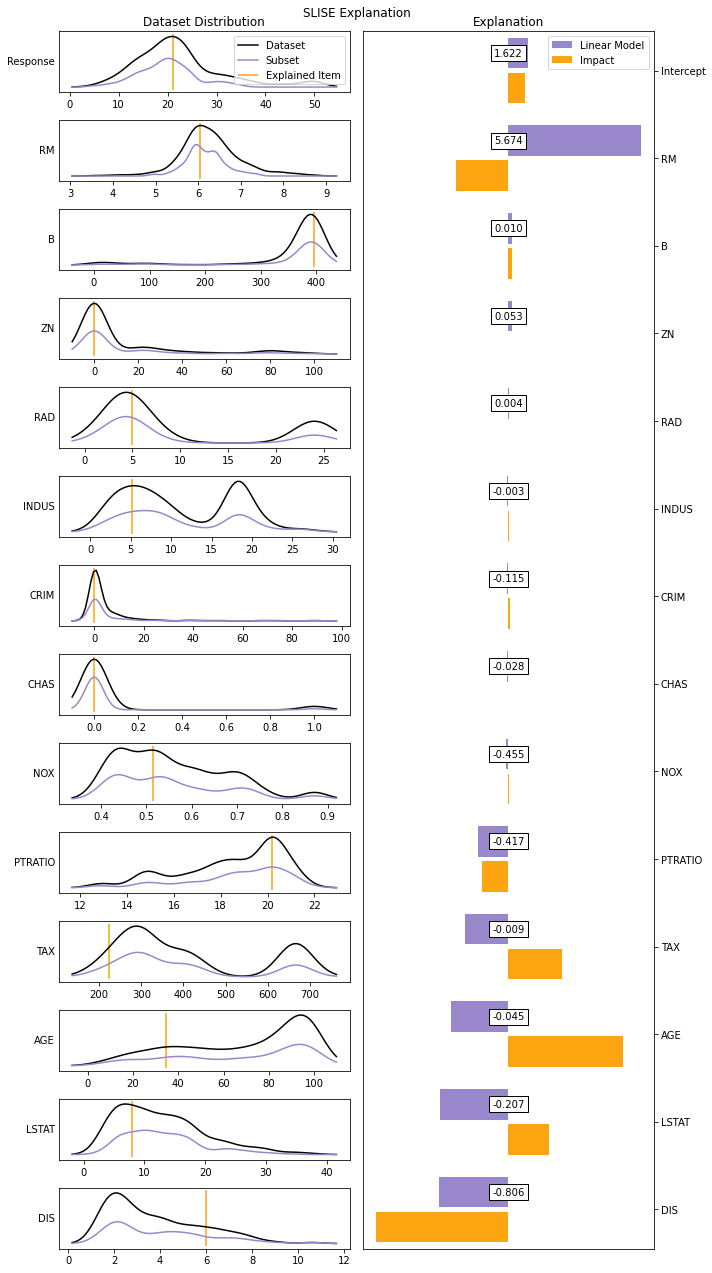

In [16]:
explanation.plot_dist(variables=variables, fig=plt.figure(figsize=(10, 18)))
plt.show()

Based on the linear model we can see that the number of rooms (RM) have a large impact on the value. However, this particular location has a very average number of rooms per dwelling, so the impact is not that large. On the other hand the location is quite far away from any employment centre, so the impact of DIS is larger for this particaular location thant what the approcimating model suggests.

Both AGE and LSTAT have a negative effect on the value (according to the linear approximation). But since the location being explained have lower values for both of these it actually supports a higher value. This "double negative" is actually represented in the impact.

The meaning of the variables are:

| Variable | Description |
|----------|-------------|
| CRIM     | per capita crime rate by town |
| ZN       | proportion of residential land zoned for lots over 25,000 sq.ft. |
| INDUS    | proportion of non-retail business acres per town |
| CHAS     | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) |
| NOX      | nitric oxides concentration (parts per 10 million) |
| RM       | average number of rooms per dwelling |
| AGE      | proportion of owner-occupied units built prior to 1940 |
| DIS      | weighted distances to five Boston employment centres |
| RAD      | index of accessibility to radial highways |
| TAX      | full-value property-tax rate per $10,000 |
| PTRATIO  | pupil-teacher ratio by town |
| B        | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town |
| LSTAT    | % lower status of the population |

The response is the median value of owner-occupied homes in $1000's.